In [535]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import time
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
import sklearn.metrics
from sklearn.model_selection import train_test_split
import math
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
from sklearn.utils import resample
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import os
from pathlib import Path



%load_ext autoreload
%autoreload 2
from NNFunctions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [704]:
x_train = pd.read_csv('./Data with correct player_atts/x_train.csv')
x_val = pd.read_csv('./Data with correct player_atts/x_val.csv')
x_test = pd.read_csv('./Data with correct player_atts/x_test.csv')

y_train = pd.read_csv('./Data with correct player_atts/y_train.csv')
y_val = pd.read_csv('./Data with correct player_atts/y_val.csv')
y_test = pd.read_csv('./Data with correct player_atts/y_test.csv')

x_train.shape, x_val.shape, x_test.shape

((12986, 47), (1239, 47), (1229, 47))

In [705]:
print('Train B365 Binary log_loss: {}'.format(log_loss(y_train.target_binary, x_train[[ 'B365H', 'B365NH']])))
print('Val B365 Binary log_loss: {}'.format(log_loss(y_val.target_binary, x_val[[ 'B365H', 'B365NH']])))
print('Test B365 Binary log_loss: {}'.format(log_loss(y_test.target_binary, x_test[[ 'B365H', 'B365NH']])))

Train B365 Binary log_loss: 0.615911339001799
Val B365 Binary log_loss: 0.6052028022570637
Test B365 Binary log_loss: 0.6248428879660936


## Initialise Models

In [6]:

input_size = len(x_train.drop(columns ='match_api_id').columns)
output_size = 3

model_dict = {

'model4': LinearNN(5, (input_size,output_size), [128,256,128,32,16], nn.ReLU(), 0.5),
'model5': LinearNN(5, (input_size,output_size), [128,512,256,128,32], nn.ReLU(), 0.5),
'model6': LinearNN(5, (input_size,output_size), [64,512,256,128,32], nn.ReLU(), 0),
'model7': LinearNN(6, (input_size,output_size), [128,256,256,128,32,16], nn.ReLU(), 0.5),
'model8': LinearNN(6, (input_size,output_size), [64,256,256,128,64,32], nn.ReLU(), 0),
'model9': LinearNN(6, (input_size,output_size), [256,512,512,128,32,16], nn.ReLU(), 0.5),
'model10': LinearNN(7, (input_size,output_size), [64,256,256,128,32,16,8], nn.ReLU(), 0.5),
'model11': LinearNN(7, (input_size,output_size), [128,256,256,128,32,16,8], nn.ReLU(), 0),
'model12': LinearNN(7, (input_size,output_size), [256,512,128,64,32,16,8], nn.ReLU(), 0.5),
'model13': LinearNN(8, (input_size,output_size), [64,128,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model14': LinearNN(8, (input_size,output_size), [128,256,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model15': LinearNN(8, (input_size,output_size), [256,512,512,128,32,16,8,8], nn.ReLU(), 0.5),
'model13': LinearNN(9, (input_size,output_size), [64,128,256,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model14': LinearNN(9, (input_size,output_size), [128,256,256,128,128,64,32,16,8], nn.ReLU(), 0.5),
'model15': LinearNN(9, (input_size,output_size), [256,512,512,256,128,32,16,8,8], nn.ReLU(), 0.5),
'model13': LinearNN(10, (input_size,output_size), [64,128,256,256,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model14': LinearNN(10, (input_size,output_size), [128,256,256,512,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model15': LinearNN(10, (input_size,output_size), [256,512,512,256,256,128,32,16,8,8], nn.ReLU(), 0.5),
}

In [6]:

input_size = len(x_train.drop(columns ='match_api_id').columns)
output_size = 3

model_dict = {

'model4': LinearNN(5, (input_size,output_size), [128,256,128,32,16], nn.ReLU(), 0.5),
'model5': LinearNN(5, (input_size,output_size), [128,512,256,128,32], nn.ReLU(), 0.5),
'model6': LinearNN(5, (input_size,output_size), [64,512,256,128,32], nn.ReLU(), 0),
'model7': LinearNN(6, (input_size,output_size), [128,256,256,128,32,16], nn.ReLU(), 0.5),
'model8': LinearNN(6, (input_size,output_size), [64,256,256,128,64,32], nn.ReLU(), 0),
'model9': LinearNN(6, (input_size,output_size), [256,512,512,128,32,16], nn.ReLU(), 0.5),
'model10': LinearNN(7, (input_size,output_size), [64,256,256,128,32,16,8], nn.ReLU(), 0.5),
'model11': LinearNN(7, (input_size,output_size), [128,256,256,128,32,16,8], nn.ReLU(), 0),
'model12': LinearNN(7, (input_size,output_size), [256,512,128,64,32,16,8], nn.ReLU(), 0.5),
'model13': LinearNN(8, (input_size,output_size), [64,128,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model14': LinearNN(8, (input_size,output_size), [128,256,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model15': LinearNN(8, (input_size,output_size), [256,512,512,128,32,16,8,8], nn.ReLU(), 0.5),
'model13': LinearNN(9, (input_size,output_size), [64,128,256,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model14': LinearNN(9, (input_size,output_size), [128,256,256,128,128,64,32,16,8], nn.ReLU(), 0.5),
'model15': LinearNN(9, (input_size,output_size), [256,512,512,256,128,32,16,8,8], nn.ReLU(), 0.5),
'model13': LinearNN(10, (input_size,output_size), [64,128,256,256,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model14': LinearNN(10, (input_size,output_size), [128,256,256,512,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model15': LinearNN(10, (input_size,output_size), [256,512,512,256,256,128,32,16,8,8], nn.ReLU(), 0.5),
}

## Train Models

In [715]:
input_size = len(x_train.drop(columns ='match_api_id').columns)
output_size = 2

model_dict = {

#'model4': LinearNN(5, (input_size,output_size), [128,256,128,32,16], nn.ReLU(), 0.2),
'model7': LinearNN('model7', 6, (input_size,output_size), [128,256,256,128,32,16], nn.ReLU(), 0),
#'model10': LinearNN('model10', 7, (input_size,output_size), [128,256,256,128,32,16,8], nn.ReLU(), 0.3),
#'model17': LinearNN('model17', 6, (input_size,output_size), [256,512,256,128,32,16], nn.ReLU(), 0.3),
#'model20': LinearNN(7, (input_size,output_size), [128,256,256,128,32,16,8], nn.ReLU(), 0.5),
# 'model11': LinearNN(7, (input_size,output_size), [128,256,512,256,64,16,8], nn.ReLU(), 0.2),
# 'model12': LinearNN('model12',8, (input_size,output_size), [256,512,512,256,128,64,16,8], nn.ReLU(), 0.4),
# 'model13': LinearNN('model13', 9, (input_size,output_size), [128,128,256,256,128,64,32,16,8], nn.ReLU(), 0.3),
# 'model14': LinearNN('model14', 9, (input_size,output_size), [128,128,256,256,128,64,32,16,8], nn.ReLU(), 0.4),

#'model15': LinearNN('model15',8, (input_size,output_size), [512,512,512,256,128,64,16,8], nn.ReLU(), 0.7),
'model16': LinearNN('model16', 9, (input_size,output_size), [256,512,256,256,128,64,32,16,8], nn.ReLU(), 0),
}

##delete previous checkpoints
for model in model_dict:
    my_file = Path("./NN checkpoints/{}checkpoint.pt".format(model))
    if my_file.is_file(): ##if file exists
        os.remove("./NN checkpoints/{}checkpoint.pt".format(model))

big_big_losses_list = [([],[]) for i in model_dict]

In [161]:
model_dict['model7'] = LinearNN(6, (input_size,output_size), [128,256,256,128,32,16], nn.ReLU(), 0.2)

In [492]:
del model_dict['model14']

In [719]:
splits = 1
results, big_losses_list = train_many(model_dict, x_train, y_train, batch_size = 2048 , splits = splits, epochs = 20, learning_rate = 0.001, use_scheduler=True, scheduler_step_size=50)

for i, model_name in enumerate(model_dict):
    for j in range(2):
        big_big_losses_list[i][j].extend(big_losses_list[i][j])
        
results


model7
Loading saved checkpoint...
Loss after iteration 0: 0.6881495714187622
Loss after iteration 100: 0.65194171667099
.  
model16
Loading saved checkpoint...
Loss after iteration 0: 0.6881088018417358
Loss after iteration 100: 0.6632043123245239
.  

,t_acc,t_loss,v_acc,v_loss
model7,0.649183,0.631379,0.640493,0.638110
model16,0.668093,0.636178,0.659738,0.641477


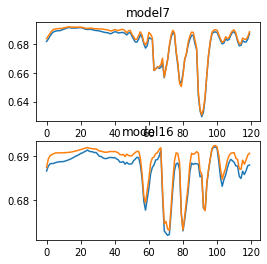

In [717]:
plot_losses(big_losses_list, model_dict, splits)

In [682]:
model_dict['model13'].get_score(x_train, y_train, scaler)

0.608690693430657 0.6797558341827923


1    7840
0     928
dtype: int64

In [684]:
## Ensemble learning
scaler = preprocessing.StandardScaler().fit(x_train.iloc[:,1:])
x_ens = get_ens_df(x_train, scaler, model_dict)
x_ens_val = get_ens_df(x_val, scaler, model_dict)
x_ens_test = get_ens_df(x_test, scaler, model_dict)


RF_clf = RandomForestClassifier(max_depth=2, random_state=0)
RF_clf.fit(x_ens, y_train['target_binary'])

print('Train Accuracy: {}'.format(RF_clf.score(x_ens, y_train['target_binary'])))
print('Val Accuracy: {}'.format(RF_clf.score(x_ens_val, y_val['target_binary'])))
print('Train log loss: {}'.format(log_loss(y_train['target_binary'], RF_clf.predict_proba(x_ens))))
print('Val log loss: {}'.format(log_loss(y_val['target_binary'], RF_clf.predict_proba(x_ens_val))))
#print('Val log loss: {}'.format(log_loss(y_test['target_binary'], RF_clf.predict_proba(x_ens_test))))

Train Accuracy: 0.7078010948905109
Val Accuracy: 0.6375757575757576
Train log loss: 0.5835000983566816
Val log loss: 0.6474753664430621


In [683]:
from sklearn.linear_model import LogisticRegression
scaler = preprocessing.StandardScaler().fit(x_train.iloc[:,1:])
x_ens = get_ens_df(x_train, scaler, model_dict)
x_ens_val = get_ens_df(x_val, scaler, model_dict)

Logistic_clf = LogisticRegression(random_state=0, C = 0.3).fit(x_ens,  y_train['target_binary'])

print('Train Accuracy: {}'.format(Logistic_clf.score(x_ens, y_train['target_binary'])))
print('Val Accuracy: {}'.format(Logistic_clf.score(x_ens_val, y_val['target_binary'])))
print('Train log loss: {}'.format(log_loss(y_train['target_binary'], Logistic_clf.predict_proba(x_ens))))
print('Val log loss: {}'.format(log_loss(y_val['target_binary'], Logistic_clf.predict_proba(x_ens_val))))

Train Accuracy: 0.6845346715328468
Val Accuracy: 0.6412121212121212
Train log loss: 0.6032453625473237
Val log loss: 0.6367683645821156


In [506]:
log_loss(y_test['target_binary'], RF_clf.predict_proba(get_ens_df(x_test, scaler, model_dict)))

0.6401525453785147

In [504]:
ensemble_predict_simple([model_dict['model12'].model, model_dict['model13'].model], x_val, y_val, scaler)

Ensemble accuracy: 0.6642424242424242
